## **1. Importing Necessary Libraries**




In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random


## **2. Defining Constants**

In [79]:
# Constants
g = 9.81  # gravity (m/s^2)
m = 0.02  # mass of the shuttlecock (kg)
C_d = 0.5  # drag coefficient
A = 0.01  # cross-sectional area of the shuttlecock (m^2)



*   **g = 9.81:** This is the acceleration due to gravity on Earth in meters per second squared (m/s²). It pulls the shuttlecock downward.

*   **m = 0.02:** The mass of the shuttlecock in kilograms (kg). This value is essential to calculate the shuttlecock's momentum and how it is affected by forces like gravity and drag.
*   **C_d = 0.5:** The drag coefficient. This constant represents how aerodynamic the shuttlecock is in the air. A drag coefficient of 0.5 indicates a relatively non-aerodynamic object, typical for a shuttlecock.
*  **A = 0.01:** The cross-sectional area of the shuttlecock in square meters (m²). This area is used to calculate the drag force the shuttlecock experiences as it moves through the air.

## **3. Generate Shuttlecock Trajectory Data**

In [80]:
def generate_trajectory_data(v_0, theta, dt=0.01, t_max=10):
    theta_rad = np.radians(theta)  # Convert angle to radians
    v_x = v_0 * np.cos(theta_rad)  # Initial horizontal velocity
    v_y = v_0 * np.sin(theta_rad)  # Initial vertical velocity
    x, y = 0, 0  # Initial position (starting at origin)
    data = []
    time = []  # To store the actual time steps

    for t in np.arange(0, t_max, dt):
        data.append([x, y, v_x, v_y])  # Append the current position and velocity
        time.append(t)  # Append the current time
        v = np.sqrt(v_x**2 + v_y**2)  # Current speed (magnitude of the velocity vector)

        # Air resistance (drag) affecting horizontal velocity (v_x)
        v_x -= (C_d * A / m) * v * v_x * dt  # Update horizontal velocity with drag force

        # Air resistance (drag) and gravity affecting vertical velocity (v_y)
        v_y -= (g + (C_d * A / m) * v * v_y) * dt  # Update vertical velocity with drag and gravity

        # Update positions based on the velocities
        x += v_x * dt  # Update horizontal position
        y += v_y * dt  # Update vertical position

        if y < 0:  # Stop the simulation if the shuttlecock hits the ground (y < 0)
            break

    return np.array(data), np.array(time)  # Return the trajectory data and actual time

In [81]:

# Simulated trajectory
data, time = generate_trajectory_data(v_0=30, theta=45)  # Initial velocity 30 m/s, angle 45 degrees
outputs_train = torch.tensor(data, dtype=torch.float32)  # The corresponding data

t_train = torch.linspace(0, len(data) * 0.01, len(data), dtype=torch.float32).view(-1, 1)  # Time

## **4. Define PiNN Model**

In [82]:
# Define PiNN model
class ShuttlecockPiNN(nn.Module):
    def __init__(self):
        super(ShuttlecockPiNN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 4)  # Outputs: x, y, v_x, v_y
        )
        self.C = 0.01  # Drag coefficient
    def forward(self, t):
        return self.hidden(t)
    def compute_ux(self, x_in):
      return torch.autograd.functional.jacobian(self, x_in, create_graph=True)

    def compute_physics_loss(self, t, outputs):
        x, y, v_x, v_y = outputs[:, 0], outputs[:, 1], outputs[:, 2], outputs[:, 3]

        # Compute derivatives using autograd
        v_pred = torch.sqrt(v_x**2 + v_y**2)  # Speed magnitude
        ax = torch.autograd.grad(v_x.sum(), t, create_graph=True)[0]
        ay = torch.autograd.grad(v_y.sum(), t, create_graph=True)[0]

        # Physics constraints: Drag and gravity forces
        fx = -self.C * v_pred * v_x
        fy = -g - self.C * v_pred * v_y

        # Physics loss (difference between predicted and calculated physics)
        physics_loss = torch.mean((ax - fx) ** 2 + (ay - fy) ** 2)
        return physics_loss

    def compute_total_loss(self, t, outputs, targets, lambda_reg=1.0):
        data_loss = torch.mean((outputs - targets) ** 2)
        physics_loss = self.compute_physics_loss(t, outputs)
        return data_loss + lambda_reg * physics_loss


# Instantiate the model
model = ShuttlecockPiNN()



In [83]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **5.Training Loop**

In [84]:
# Training loop
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    t_train.requires_grad = True  # Enable gradient computation for time
    predictions = model(t_train)
    loss = model.compute_total_loss(t_train, predictions, outputs_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 121.60891723632812
Epoch 100, Loss: 4.869398593902588
Epoch 200, Loss: 4.835516929626465
Epoch 300, Loss: 4.829470157623291
Epoch 400, Loss: 4.826657295227051
Epoch 500, Loss: 4.824942111968994
Epoch 600, Loss: 4.823761463165283
Epoch 700, Loss: 4.822886943817139
Epoch 800, Loss: 4.822249889373779
Epoch 900, Loss: 4.821802616119385
Epoch 1000, Loss: 4.821492671966553
Epoch 1100, Loss: 4.821284770965576
Epoch 1200, Loss: 4.821142673492432
Epoch 1300, Loss: 4.821045398712158
Epoch 1400, Loss: 4.820973873138428
Epoch 1500, Loss: 4.820919990539551
Epoch 1600, Loss: 4.820876121520996
Epoch 1700, Loss: 4.820840358734131
Epoch 1800, Loss: 4.820809841156006
Epoch 1900, Loss: 4.820782661437988


## **6.Visualization of True vs Predicted Shuttlecock Trajectory**

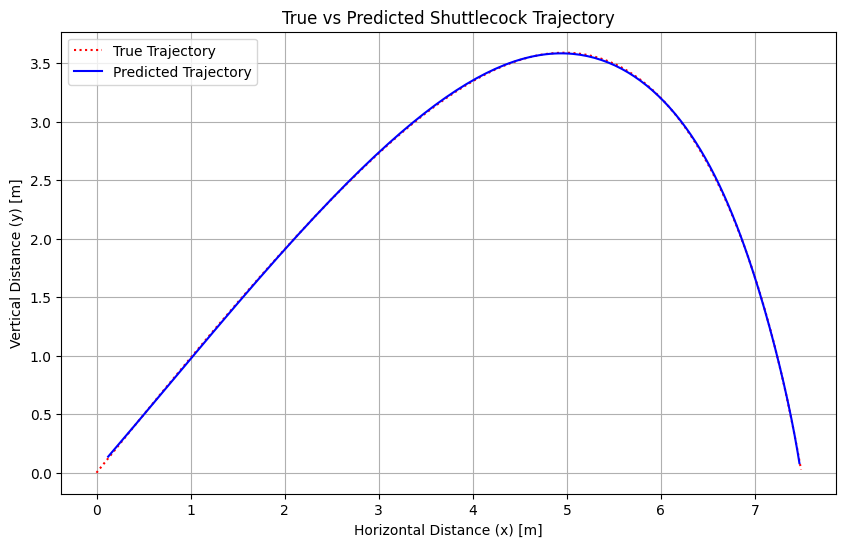

In [85]:
# Visualize results
predicted = model(t_train).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(data[:, 0], data[:, 1], label="True Trajectory", linestyle='dotted', color='red')
plt.plot(predicted[:, 0], predicted[:, 1], label="Predicted Trajectory", linestyle='solid', color='blue')
plt.xlabel("Horizontal Distance (x) [m]")
plt.ylabel("Vertical Distance (y) [m]")
plt.title("True vs Predicted Shuttlecock Trajectory")
plt.legend()
plt.grid()
plt.show()


## **7.Selecting Representative Points for Training**
In this step, we will select a subset of the simulated trajectory data to use for training the model. Given that the full trajectory dataset may contain a large number of time steps, we select only a few key points (evenly spaced) to reduce the complexity of the problem while still maintaining the essential features of the trajectory.

We use ***num_points=20*** to select ***20*** evenly spaced points from the trajectory data.
The selected points will be used as inputs for training the Physics-informed Neural Network (PiNN) model.
The function select_representative_points takes in the full dataset and the corresponding time steps, and it returns the selected points and their corresponding times.

In [86]:
# Select Representative Points for Training
def select_representative_points(data, time, num_points=20):
    indices = np.linspace(0, len(data) - 1, num_points, dtype=int)  # Evenly spaced points
    return data[indices], time[indices]  # Return selected data and corresponding time


In [87]:
# Select 20 representative points
data_20_points, time_20_points = select_representative_points(data, time, num_points=15)

# Prepare training data
t_train_20 = torch.tensor(time_20_points, dtype=torch.float32).view(-1, 1)  # Time for the selected points
outputs_train_20 = torch.tensor(data_20_points, dtype=torch.float32)  # The corresponding data



In [88]:
# Instantiate the model
model2 = ShuttlecockPiNN()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Lists to track loss values for plotting
loss_values = []

# Training loop
epochs = 2000
lambda_reg = 1.0  # Regularization parameter for physics loss
for epoch in range(epochs):
    optimizer.zero_grad()
    t_train_20.requires_grad = True
    outputs_pred = model2(t_train_20)
    loss2 = model2.compute_total_loss(t_train_20, outputs_pred, outputs_train_20, lambda_reg)


    loss2.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss2.item()}")
        # Store the loss for plotting
        loss_values.append(loss2.item())


Epoch 0, Loss: 130.25904846191406
Epoch 100, Loss: 9.192829132080078
Epoch 200, Loss: 9.15469741821289
Epoch 300, Loss: 9.14697265625
Epoch 400, Loss: 9.14273738861084
Epoch 500, Loss: 9.139516830444336
Epoch 600, Loss: 9.135921478271484
Epoch 700, Loss: 9.120284080505371
Epoch 800, Loss: 9.336146354675293
Epoch 900, Loss: 8.293047904968262
Epoch 1000, Loss: 9.165619850158691
Epoch 1100, Loss: 9.13359546661377
Epoch 1200, Loss: 9.065622329711914
Epoch 1300, Loss: 8.784505844116211
Epoch 1400, Loss: 7.950781345367432
Epoch 1500, Loss: 6.738585948944092
Epoch 1600, Loss: 5.1662163734436035
Epoch 1700, Loss: 4.550174713134766
Epoch 1800, Loss: 4.37558126449585
Epoch 1900, Loss: 4.290517807006836


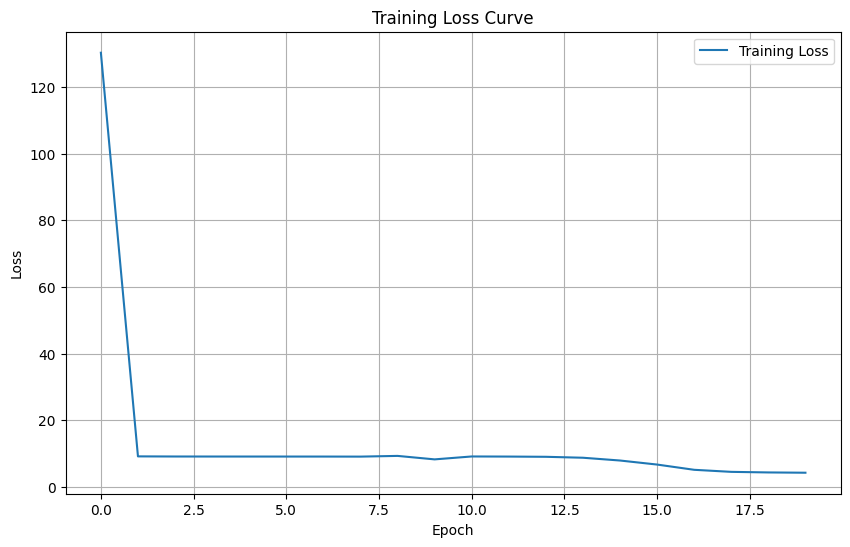

In [89]:
# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
# Predict the full trajectory
t_full = torch.linspace(0, len(data) * 0.01, len(data)).view(-1, 1).float()
predicted_full_trajectory = model2(t_full).detach().numpy()


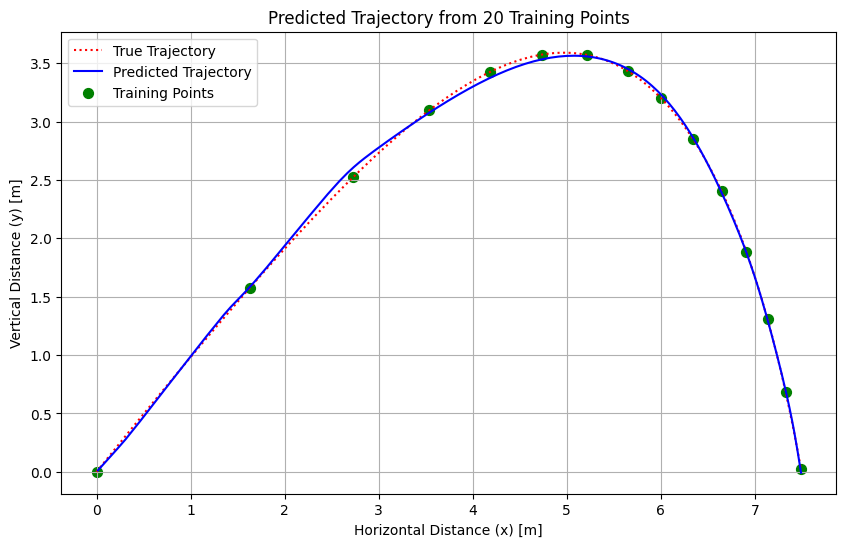

In [92]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(data[:, 0], data[:, 1], label="True Trajectory", linestyle="dotted", color="red")
plt.plot(predicted_full_trajectory[:, 0], predicted_full_trajectory[:, 1], label="Predicted Trajectory", linestyle="solid", color="blue")
plt.scatter(data_20_points[:, 0], data_20_points[:, 1], label="Training Points", color="green", s=50)
plt.xlabel("Horizontal Distance (x) [m]")
plt.ylabel("Vertical Distance (y) [m]")
plt.title("Predicted Trajectory from 20 Training Points")
plt.legend()
plt.grid()
plt.show()


## **8.Evalution**
### 1.RMSE

In [93]:
def calculate_accuracy(predicted, true):
    # Calculate the difference between predicted and true values
    x_diff = predicted[:, 0] - true[:, 0]
    y_diff = predicted[:, 1] - true[:, 1]
    velocity_diff = np.sqrt((predicted[:, 2] - true[:, 2]) ** 2 + (predicted[:, 3] - true[:, 3]) ** 2)

    # Calculate the RMSE for positions and velocities
    position_rmse = np.sqrt(np.mean(x_diff ** 2 + y_diff ** 2))
    velocity_rmse = np.mean(velocity_diff)

    return position_rmse, velocity_rmse

# Calculate detection accuracy
position_rmse, velocity_rmse = calculate_accuracy(predicted_full_trajectory, data)
print(f"Position RMSE: {position_rmse}")
print(f"Velocity RMSE: {velocity_rmse}")


Position RMSE: 0.1235337175527341
Velocity RMSE: 2.263078995539549


### 2.detection_accuracy

In [95]:
import numpy as np

# Function to calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
def calculate_tp_fp_fn(predicted, true, epsilon=0.3):
    # Calculate the Euclidean distance between predicted and true positions
    distances = np.sqrt((predicted[:, 0] - true[:, 0]) ** 2 + (predicted[:, 1] - true[:, 1]) ** 2)

    # True Positives: Points within epsilon distance from the true trajectory
    tp = np.sum(distances <= epsilon)

    # False Positives: Predicted points that are outside epsilon distance
    fp = np.sum(distances > epsilon)

    # False Negatives: True points that do not match any predicted points within epsilon distance
    # We assume FN are the true points that do not have any predicted point in the range
    fn = len(true) - tp

    return tp, fp, fn

# Function to calculate detection accuracy using TP, FP, and FN
def calculate_detection_accuracy(tp, fp, fn):
    # Calculate detection accuracy
    total = tp + fp + fn
    if total == 0:
        return 0.0  # Avoid division by zero if there are no predictions or true points
    accuracy = tp / total
    return accuracy


# Calculate TP, FP, FN
tp, fp, fn = calculate_tp_fp_fn(predicted_full_trajectory, data, epsilon=0.3)

# Calculate detection accuracy
accuracy = calculate_detection_accuracy(tp, fp, fn)
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Detection Accuracy: {accuracy:.4f}")


True Positives (TP): 158
False Positives (FP): 9
False Negatives (FN): 9
Detection Accuracy: 0.8977


### 3. Inference Latency


In [96]:
import time

# Measure inference latency
start_time = time.time()
predicted_full_trajectory = model(t_full).detach().numpy()
end_time = time.time()

inference_latency = end_time - start_time
print(f"Inference Latency: {inference_latency:.4f} seconds")


Inference Latency: 0.0035 seconds
